<a href="https://colab.research.google.com/github/clyde2020/ML_Portfolio/blob/main/US%20Cancer%20Death%20Rates/Capstone_2_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from numpy.random import seed

In [ ]:
# Load the data
cancer = '/content/cancer_reg.csv'
df = pd.read_csv(cancer, encoding='latin-1')

In [ ]:
# Drop 1 column with lots of null values 
df.drop('PctSomeCol18_24', axis=1, inplace=True)
# Impute the mean for the other null values
df.PctPrivateCoverageAlone = df.PctPrivateCoverageAlone.fillna(df.PctPrivateCoverageAlone.mean())
df.PctEmployed16_Over = df.PctEmployed16_Over.fillna(df.PctEmployed16_Over.mean())
# binnedInc and medIncome reflect the same info. We will get rid of binnedInc with dtype = object
# df.drop('binnedInc', axis=1, inplace=True)
# Geography column is split into individual cities. We prefer to have state info.
df['state'] = df['Geography'].str.split(',', expand=True)[1]

In [ ]:
# Median age has maximum of 624!
df.MedianAge.describe()

count    3047.000000
mean       45.272333
std        45.304480
min        22.300000
25%        37.700000
50%        41.000000
75%        44.000000
max       624.000000
Name: MedianAge, dtype: float64

In [ ]:
len(df[df.MedianAge > 66])

30

In [ ]:
# There's only 30 records with unreasonable median ages, so we'll drop those
df = df[df.MedianAge < 70]

In [ ]:
df.MedianAge.describe()

count    3017.000000
mean       40.823865
std         5.196933
min        22.300000
25%        37.700000
50%        40.900000
75%        43.800000
max        65.300000
Name: MedianAge, dtype: float64

In [ ]:
df.describe().T

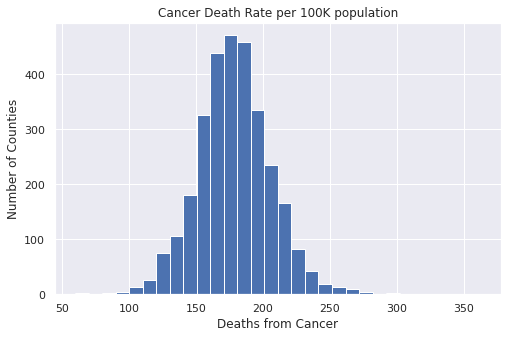

In [ ]:
# Target death rate is almost normally distributed at first glance
sns.set(rc = {'figure.figsize':(8,5)})
_ = plt.hist(df['TARGET_deathRate'], bins=30)
_ = plt.title('Cancer Death Rate per 100K population')
_ = plt.xlabel('Deaths from Cancer')
_ = plt.ylabel('Number of Counties')

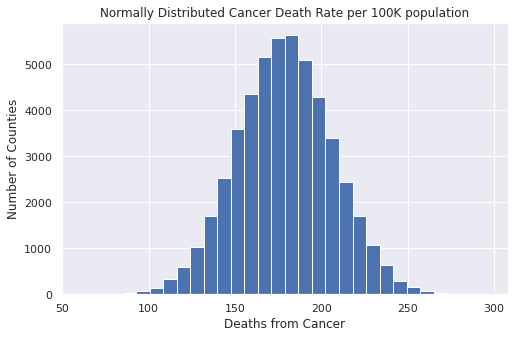

In [ ]:
seed(47)
sns.set(rc = {'figure.figsize':(8,5)})
# Pick population of 50000 from normal distribution
death_mean = np.mean(df['TARGET_deathRate'])
death_std = np.std(df['TARGET_deathRate'])
death = norm.rvs(death_mean, death_std, size=50000)
_ = plt.hist(death, bins=30)
_ = plt.title('Normally Distributed Cancer Death Rate per 100K population')
_ = plt.xlabel('Deaths from Cancer')
_ = plt.ylabel('Number of Counties')

In [ ]:
df.groupby('state')['TARGET_deathRate'].mean().sort_values(ascending=False)

state
 Kentucky                214.876471
 Mississippi             202.790123
 Tennessee               201.177660
 Arkansas                200.090667
 Louisiana               197.523810
 West Virginia           196.710909
 Oklahoma                193.949351
 Alaska                  193.416667
 Alabama                 192.728571
 Missouri                189.449123
 South Carolina          188.506522
 Indiana                 188.120652
 Ohio                    186.882759
 Illinois                183.375248
 Georgia                 183.352318
 Maine                   183.150000
 Virginia                182.855285
 District of Columbia    182.300000
 Florida                 179.430303
 Delaware                178.866667
 North Carolina          177.655208
 Michigan                177.631707
 Nevada                  177.435294
 Maryland                176.479167
 Vermont                 176.271429
 Pennsylvania            175.059375
 Wisconsin               172.373611
 New York             

In [ ]:
# Now let's get the high and low averages per state
hi_dr = df.groupby('state')['TARGET_deathRate'].mean().sort_values(ascending=False)[0]
lo_dr = df.groupby('state')['TARGET_deathRate'].mean().sort_values(ascending=False)[-1]

In [ ]:
# Let's see where they fall in the CDF
death_norm = norm(death_mean, death_std)
print(death_norm.cdf(lo_dr))
print(death_norm.cdf(hi_dr))

0.06095687948438355
0.904282905102003


In [ ]:
def death_sampler(n):
    return np.random.choice(death, n)

In [ ]:
# We will get a sample from the normally distributed population
sample = death_sampler(len(df))

In [ ]:
s_mean = np.mean(sample)
s_std = np.std(sample)
s_mean, s_std

(178.75225340653589, 27.597434028953327)

In [ ]:
z = 1.96
margin_of_error = z * s_std
margin_of_error

54.09097069674852

In [ ]:
# We'll measure the 95% confidence intervals
low_ci = s_mean - margin_of_error
high_ci = s_mean + margin_of_error
low_ci, high_ci

(124.66128270978737, 232.8432241032844)

In [ ]:
t = 2.01
margin_of_error = t * s_std
low_ci = s_mean - margin_of_error
high_ci = s_mean + margin_of_error
low_ci, high_ci

(123.2814110083397, 234.22309580473205)

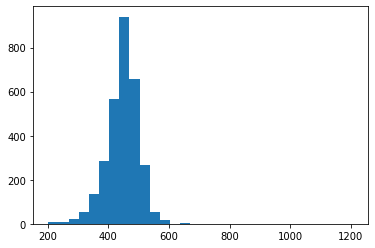

In [ ]:
# Incidence rate does not appear to be normally distributed
_ = plt.hist(df['incidenceRate'], bins=30)

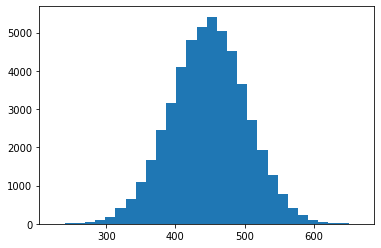

In [ ]:
inc_mean = np.mean(df['incidenceRate'])
inc_std = np.std(df['incidenceRate'])
incidence = norm.rvs(inc_mean, inc_std, size=50000)
_ = plt.hist(incidence, bins=30)

In [ ]:
# We'll look at Median incomes vs target
df['binnedIncNum'] = df['binnedInc'].str.strip('(').str.strip('[').str.split(',', expand=True)[0]
order = sorted(df['binnedIncNum'].unique())

In [ ]:
df_22640 = df[df.binnedIncNum == '22640']
df_22640.TARGET_deathRate.mean()

202.77664473684223

In [ ]:
df[df.binnedIncNum == '61494.5'].TARGET_deathRate.mean()

158.99966329966344

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cancer Death Rate related to Income')

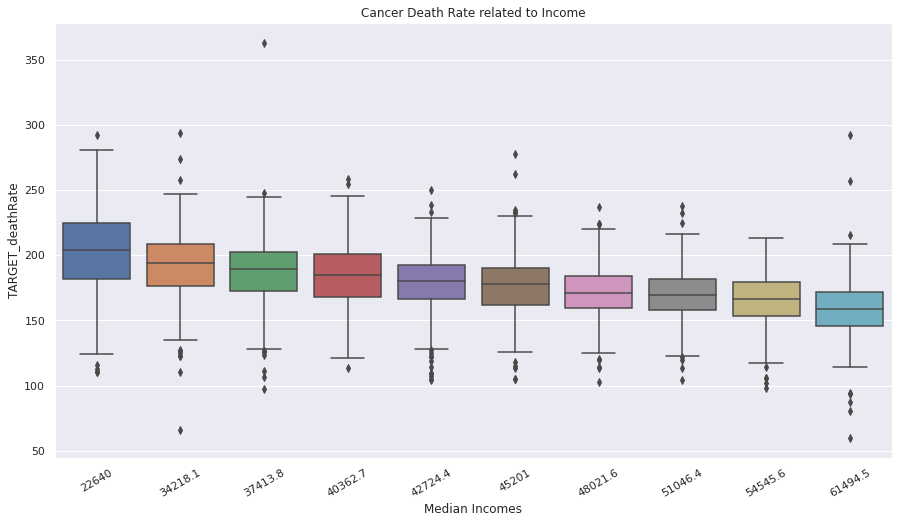

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.boxplot('binnedIncNum', 'TARGET_deathRate', data=df, order=order)
ax.set_xlabel('Median Incomes')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_title('Cancer Death Rate related to Income')

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avgAnnCount,3017.0,607.573376,1422.111040,6.000000,76.000000,170.000000,515.000000,3.815000e+04
avgDeathsPerYear,3017.0,186.285714,506.346011,3.000000,28.000000,61.000000,147.000000,1.401000e+04
TARGET_deathRate,3017.0,178.648194,27.737080,59.700000,161.300000,178.100000,195.200000,3.628000e+02
incidenceRate,3017.0,448.154402,54.608081,201.300000,420.300000,453.549422,480.800000,1.206900e+03
medIncome,3017.0,47060.539277,12053.191812,22640.000000,38887.000000,45207.000000,52476.000000,1.256350e+05
popEst2015,3017.0,102718.943984,330286.240541,827.000000,11703.000000,26589.000000,68502.000000,1.017029e+07
povertyPercent,3017.0,16.882400,6.416020,3.200000,12.200000,15.800000,20.400000,4.740000e+01
studyPerCap,3017.0,156.586892,532.071270,0.000000,0.000000,0.000000,83.896902,9.762309e+03
MedianAge,3017.0,40.823865,5.196933,22.300000,37.700000,40.900000,43.800000,6.530000e+01
MedianAgeMale,3017.0,39.568445,5.225173,22.400000,36.400000,39.500000,42.600000,6.470000e+01


In [ ]:
df.groupby('state')['incidenceRate'].mean().sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cancer Death Rate related to Education')

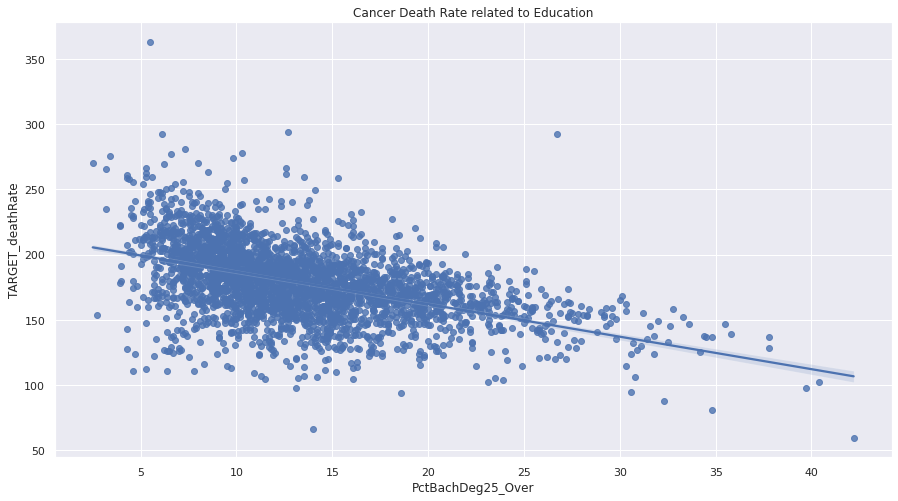

In [ ]:
sns.regplot('PctBachDeg25_Over', 'TARGET_deathRate', data=df).set_title('Cancer Death Rate related to Education')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cancer Death Rate related to Poverty')

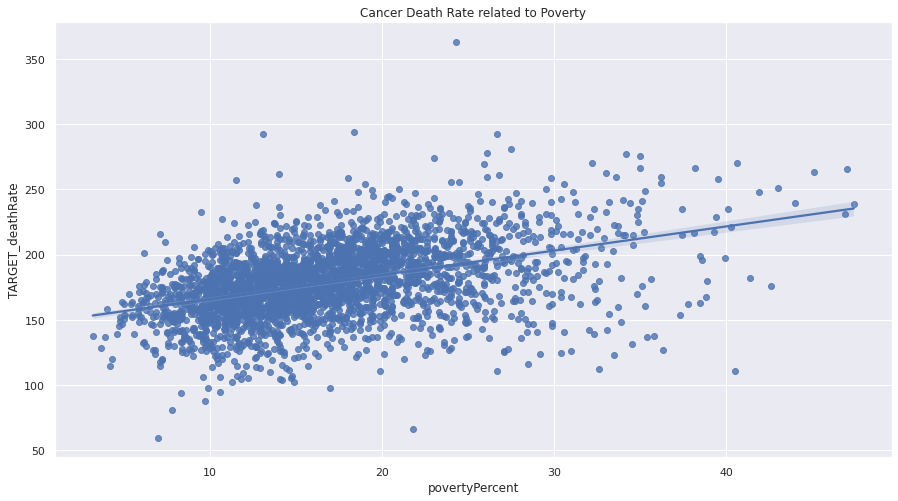

In [ ]:
sns.regplot('povertyPercent', 'TARGET_deathRate', data=df).set_title('Cancer Death Rate related to Poverty')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


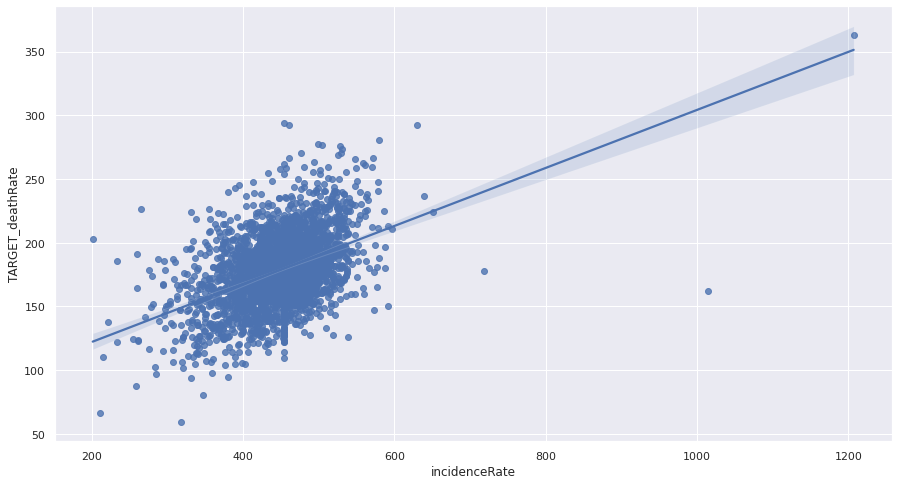

In [ ]:
# How does incidence rate relate to target
sns.regplot('incidenceRate', 'TARGET_deathRate', data=df)

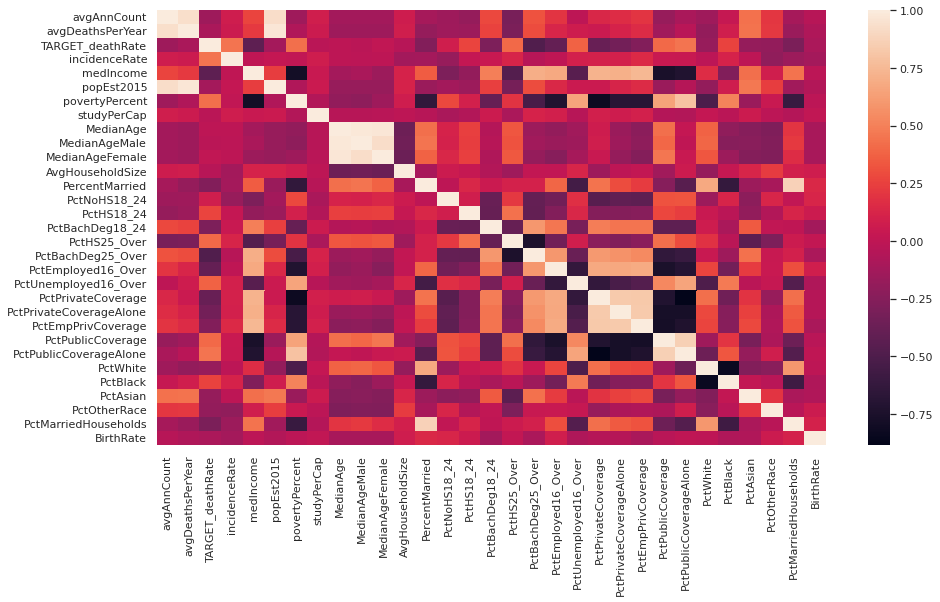

In [ ]:
# We'll get a visual of the correlations
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.corr())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


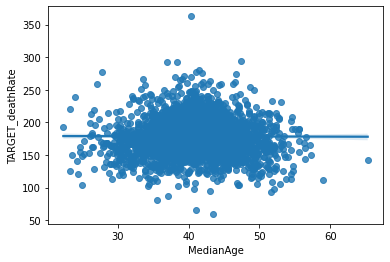

In [ ]:
# I thought Median age would explain some of the death rate. I was wrong!
sns.regplot('MedianAge', 'TARGET_deathRate', data=df)

In [ ]:
def pearson_r(x, y):
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0,1]

In [ ]:
# We'll get Pearson R values for all features
sub_df = df.drop(['Geography', 'state'], axis=1)
target = df['TARGET_deathRate']
cols = sub_df.columns

In [ ]:
pearsons = [pearson_r(sub_df[col], target) for col in cols]
results = pd.DataFrame(zip(cols, pearsons), columns=['column', 'pearson'])
results.sort_values('pearson')

,column,pearson
17,PctBachDeg25_Over,-0.485203
4,medIncome,-0.427823
18,PctEmployed16_Over,-0.397961
20,PctPrivateCoverage,-0.384792
21,PctPrivateCoverageAlone,-0.326504
29,PctMarriedHouseholds,-0.293577
15,PctBachDeg18_24,-0.288533
12,PercentMarried,-0.266849
22,PctEmpPrivCoverage,-0.264728
28,PctOtherRace,-0.188331


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7034a0e50>,
      dtype=object)

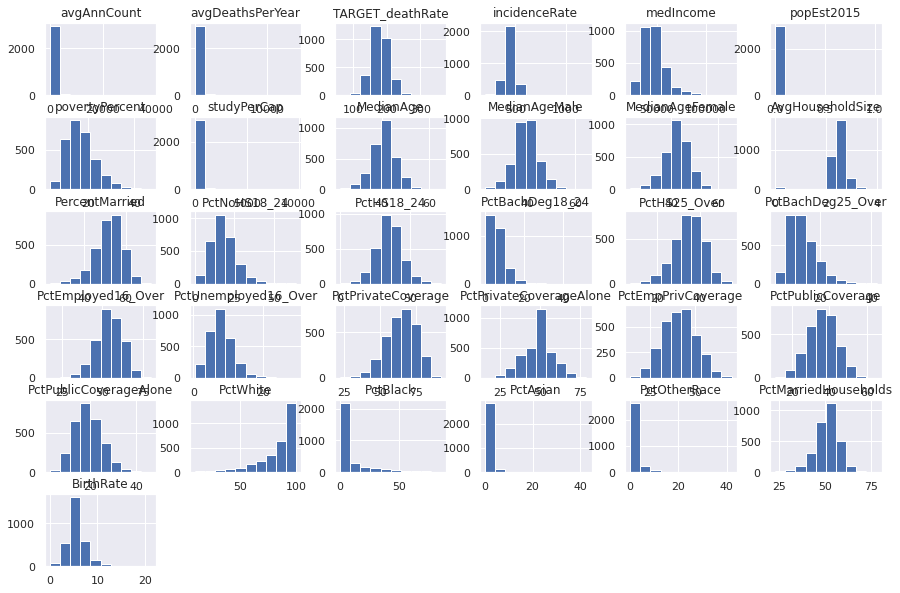

In [ ]:
df.hist(figsize=(15, 10))

In [ ]:
states = df.groupby('state').mean().reset_index()

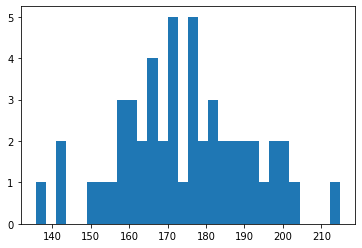

In [ ]:
_ = plt.hist(states['TARGET_deathRate'], bins=30)

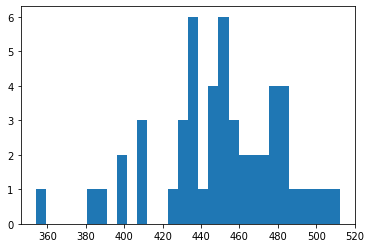

In [ ]:
_ = plt.hist(states['incidenceRate'], bins=30)

No new info from state distributions